# Step 1: Setup Torch Data Loader

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
class DigitsData(Dataset):
    def __init__(self, foldername):
        # Pre-load and remember digits in ram so they can be 
        # quickly accessed (this is not always feasible if the
        # dataset is too big)
        res = 28
        digits = []
        for i in range(10):
            digits.append([])
            I = skimage.io.imread("{}/{}.png".format(foldername, i))/255.0
            row = 0
            col = 0
            while row < I.shape[0]:
                col = 0
                while col < I.shape[1]:
                    img = I[row:row+res, col:col+res]
                    if np.sum(img) > 0:
                        digits[i].append(img)
                    col += res
                row += res
            #print(len(digits[i]), "unique ", i, " digits")
        self.digits = digits
    
    def __len__(self):
        return sum([len(d) for d in self.digits])
    
    def __getitem__(self, idx):
        y = 0
        while len(self.digits[y]) <= idx:
            idx -= len(self.digits[y])
            y += 1
        # Note that torch tensors and weights are 32 bits by default
        # so we should convert our dataset to that format
        x = np.array(self.digits[y][idx], np.float32).flatten()
        # Create a 1-hot vector representing the output class
        yhot = np.zeros(len(self.digits), dtype=np.float32)
        yhot[y] = 1
        # Convert to torch tensors
        return torch.from_numpy(x), torch.from_numpy(yhot)
    
training = DigitsData("Digits")
testing = DigitsData("DigitsTest")
print("len(trainin)", len(training))
print("len(testing)", len(testing))

len(trainin) 60000
len(testing) 10000


Now we can create a data loader and take out a random batch to look at

X.shape torch.Size([16, 784])
Y.shape torch.Size([16, 10])


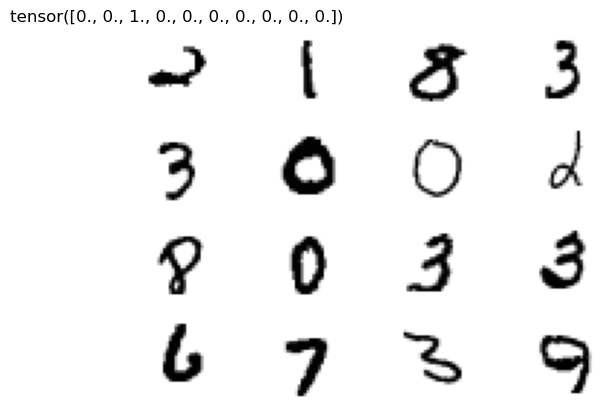

In [17]:
loader = DataLoader(training, batch_size=16, shuffle=True)
X, Y = next(iter(loader))
print("X.shape", X.shape)
print("Y.shape", Y.shape)

for i in range(X.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(X[i, :].view(28, 28), cmap='gray', vmin=0, vmax=1)
    if i == 0:
        plt.title("{}".format(Y[i, :]))
    plt.axis("off")

# Training A Multiclass Logistic Regression Network

Setup a training loop to do "mini batch graident descent"

Loop through all of the training data a bunch of times and update the weight and bias parameters via gradient descent

Our architecture is going to be a single linear layer followed by softmax, which is the setup for multiclass logistic regression:

<img src = "MulticlassLogistic.svg">


In [7]:
linear = nn.Linear(28*28, 10) # This has W and b in it
optimizer = torch.optim.Adam(linear.parameters(), lr=1e-3)
loss_fn = torch.nn.BCEWithLogitsLoss() # Function that I can use to do 
# binary cross-entropy loss

n_epochs = 50
losses = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
for epoch in range(n_epochs):
    loader = DataLoader(training, batch_size=64, shuffle=True)
    total_loss = 0
    num_correct = 0
    for X, Y in loader:
        # Go through each batch
        Y_est = linear(X)
        # Sum up the losses for each example
        loss = loss_fn(Y_est, Y)
        # Compute the number of examples that are correct
        num_correct += torch.sum(torch.argmax(Y_est, dim=1) 
                                 == torch.argmax(Y, dim=1)).item()
        
        # Compute the gradient of the loss function 
        # with respect to all parameterse in the optimizer
        loss.backward()
        # Apply gradient descent
        optimizer.step()
        # Clear accumulated gradients for next time
        optimizer.zero_grad() 
        
        # Accumulate the loss over all batches
        total_loss += loss.item() # (Don't keep taking gradients)
    
    losses[epoch] = total_loss
    accuracy[epoch] = num_correct / len(training)
    
    print("Epoch {}, loss {:.3f}, accuracy {:.3f}".format(epoch, losses[epoch], accuracy[epoch]))

Epoch 0, loss 138.865, accuracy 0.789
Epoch 1, loss 86.124, accuracy 0.874
Epoch 2, loss 77.864, accuracy 0.885
Epoch 3, loss 74.223, accuracy 0.891
Epoch 4, loss 72.090, accuracy 0.895
Epoch 5, loss 70.745, accuracy 0.897
Epoch 6, loss 69.607, accuracy 0.900
Epoch 7, loss 69.019, accuracy 0.901
Epoch 8, loss 68.060, accuracy 0.903
Epoch 9, loss 67.479, accuracy 0.904
Epoch 10, loss 67.097, accuracy 0.905
Epoch 11, loss 66.740, accuracy 0.905
Epoch 12, loss 66.440, accuracy 0.906
Epoch 13, loss 66.179, accuracy 0.907
Epoch 14, loss 65.683, accuracy 0.908
Epoch 15, loss 65.664, accuracy 0.909
Epoch 16, loss 65.368, accuracy 0.909
Epoch 17, loss 65.227, accuracy 0.909
Epoch 18, loss 64.809, accuracy 0.910
Epoch 19, loss 64.727, accuracy 0.910
Epoch 20, loss 64.698, accuracy 0.909
Epoch 21, loss 64.521, accuracy 0.911
Epoch 22, loss 64.341, accuracy 0.911
Epoch 23, loss 64.202, accuracy 0.911
Epoch 24, loss 63.884, accuracy 0.911
Epoch 25, loss 63.990, accuracy 0.912
Epoch 26, loss 63.639

Text(0.5, 1.0, 'Loss Curve')

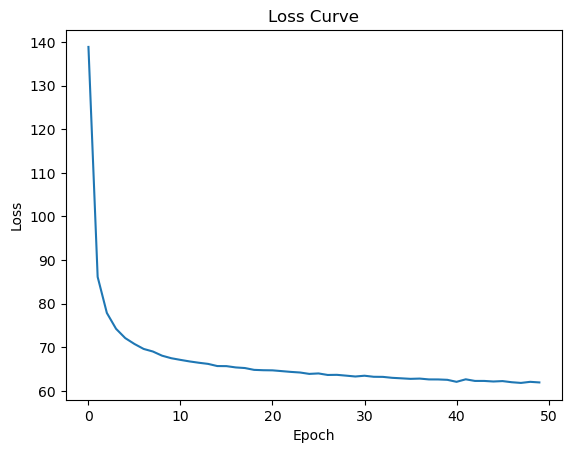

In [10]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")

Text(0, 0.5, 'Accuracy')

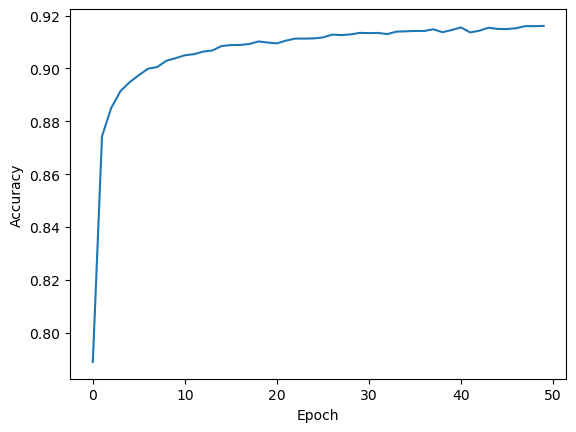

In [11]:
plt.plot(accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

We do well on the test data, so our model that we trained "generalized" to unseen examples

In [9]:
loader = DataLoader(testing, batch_size=len(testing), shuffle=True)
total_loss = 0
num_correct = 0
X, Y = next(iter(loader))
Y_est = linear(X)
# Compute the number of examples that are correct
num_correct = torch.sum(torch.argmax(Y_est, dim=1) 
                         == torch.argmax(Y, dim=1)).item()
print(num_correct/len(testing))

0.9149


Text(0.5, 1.0, 'Bias')

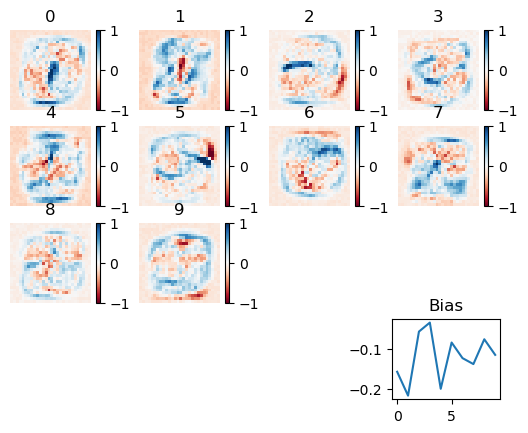

In [19]:
W, b = linear.parameters()
for i in range(10):
    plt.subplot(4, 4, i+1)
    plt.imshow(W[i, :].detach().view(28, 28), cmap='RdBu', interpolation='none', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("{}".format(i))
    plt.axis("off")
    
plt.subplot(4, 4, 16)
plt.plot(b.detach())
plt.title("Bias")